In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
print(cv2.__version__)

4.6.0


In [5]:
path_cfg = "/Users/reejungkim/Documents/Git/ImgProcessor/YOLO/yolov2-tiny.cfg"
path_weights = "/Users/reejungkim/Documents/Git/ImgProcessor/YOLO/yolov2-tiny.weights"
path_names = "/Users/reejungkim/Documents/Git/ImgProcessor/YOLO/yolo.names"

path_img = "/Users/reejungkim/Documents/Git/ImgProcessor/YOLO/people.jpg"

path_video = "/Users/reejungkim/Documents/Git/ImgProcessor/YOLO/Street.mp4"

In [6]:
# Load Yolo
net = cv2.dnn.readNet(path_cfg, path_weights)
classes = []
with open(path_names, "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]  #output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

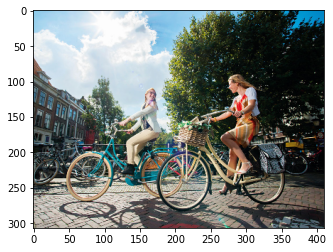

In [7]:
# Loading image
img = cv2.imread(path_img)
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape


#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow( cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

#### Blob and find objects using the net
YOLO accepts three sizes:

320×320 it’s small so less accuracy but better speed

609×609 it’s bigger so high accuracy and slow speed

416×416 it’s in the middle and you get a bit of both.

In [8]:
# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

#### Show result
calculate confidence and confidence threshold. 

The threshold goes from 0 to 1. The closer to 1 the greater is the accuracy of the detection, while the closer to 0 the less is the accuracy but also it’s greater the number of the objects detected.

In [9]:
# Showing informations on the screen
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5: #if it’s greater consider the object correctly detected, otherwise skip it.
        #if confidence > 0.5 and class_id == 0 : # to box objects labelled as persons only
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

#### Non maximum suppresion
remove this “noise” - having multiple boxes for the same object

[설명](https://deep-learning-study.tistory.com/403)
bounding boxes 목록에 남아있는 bounding box에서 가장 높은 점수를 갖고 있는 것을 선택하고 목록에서 제거. 그리고 final box에 추가. 반복.

In [10]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

True

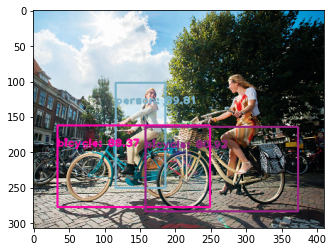

In [11]:
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = "{}: {:.2f}".format(classes[class_ids[i]], confidences[i]*100) #str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 1, color, 2) #cv2.putText(img, text, org, fontFace, fontScale, color, thickness, lineType, bottomLeftOrigin)


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow( img )
#cv2.imshow("Image", img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#for i in range(5):
#    cv2.waitKey(1)

# 다른이름으로 저장하기
cv2.imwrite('result.png', img)

## Video

In [12]:

import time

min_confidence = 0.5

def detectAndDisplay(frame):
    start_time = time.time()
    img = cv2.resize(frame, None, fx=0.8, fy=0.8)
    height, width, channels = img.shape
    #cv2.imshow("Original Image", img)

    #-- 창 크기 설정
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    #-- 탐지한 객체의 클래스 예측 
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            #-- 원하는 class id 입력 / coco.names의 id에서 -1 할 것 
            if class_id == 0 and confidence > min_confidence:
                #-- 탐지한 객체 박싱
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
               
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
    font = cv2.FONT_HERSHEY_DUPLEX
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = "{}: {:.2f}".format(classes[class_ids[i]], confidences[i]*100)
            print(i, label)
            color = colors[i] #-- 경계 상자 컬러 설정 / 단일 생상 사용시 (255,255,255)사용(B,G,R)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y - 5), font, 1, color, 1)
    end_time = time.time()
    process_time = end_time - start_time
    print("=== A frame took {:.3f} seconds".format(process_time))
    cv2.imshow("YOLO test", img)
    cv2.waitKey(0)


#-- GPU 사용
#net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
#net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

#-- 클래스(names파일) 오픈 / 본인 개발 환경에 맞게 변경할 것
classes = []
with open(path_names, "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))


In [14]:

#-- 비디오 활성화
cap = cv2.VideoCapture(path_video) #-- 웹캠 사용시 vedio_path를 0 으로 변경
if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)
while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break
    detectAndDisplay(frame)
    #-- q 입력시 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

=== A frame took 0.042 seconds


In [1]:
cv2.waitKey(0)
cv2.destroyAllWindows()
for i in range(5):
    cv2.waitKey(1)

NameError: name 'cv2' is not defined